In [8]:
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import pandas as pd
from modAL import batch, uncertainty
from sklearn import tree
from tqdm.notebook import tqdm
from importlib import reload

from libadversarial import random_batch, uncertainty_id, fgm, deepfool
from libplot import plot_classification
from libutil import ProgressParallel
from libactive import MyActiveLearner, active_learn, active_learn2, active_split

In [9]:
def loadData_banknote_complete(dataset_size=1372):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
    dataset = pd.read_csv(url, header=None)
    y = dataset[4].to_numpy()
    isInB = np.array([dataset.to_numpy()[i,0]>0.32 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    X = dataset.drop([4], axis=1).to_numpy()
    #pca = PCA(n_components=21).fit(X)
    #X = pca.transform(X)
    X = np.append(X, isInB, axis=1)
    
    return X, y

In [10]:
X, y = loadData_banknote_complete()
# this should have been done by above but *shrug*
X = np.delete(X, 4, axis=1)

In [11]:
query_methods = {
    "uncertainty": batch.uncertainty_batch_sampling,
    "random": random_batch,
    #"margin": uncertainty.margin_sampling,
    #"entropy": uncertainty.entropy_sampling,
    "uncertainty_id": uncertainty_id,
    "deepfool": deepfool,
    "fgm": fgm
}

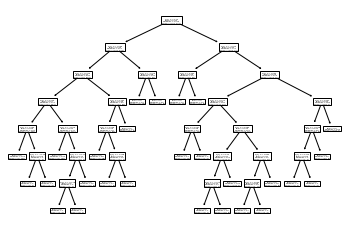

In [12]:
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X, y)
tree.plot_tree(tree_clf);

<ipython-input-15-26f3cbf9a395>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


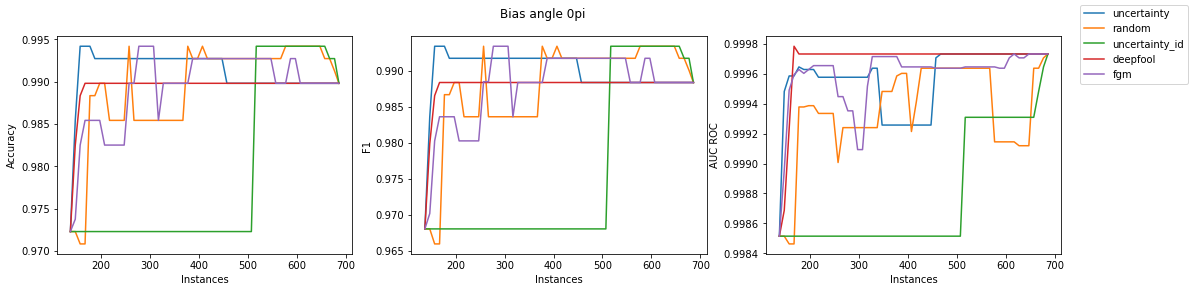

In [15]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)
    
fig, axes = plt.subplots(1, 3, figsize=(18,4))

for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
    learner = MyActiveLearner(animate=False)
    metrics = learner.active_learn2(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method, n_instances=10)).frame
    metrics.to_csv(f"Experiments/experiment_banknote_method_{method.__name__}.csv")

    for i, ax in enumerate(axes.flatten()):
        ax.plot(metrics['x'], metrics.iloc[:,1+i], label=f"{name}" if i == 0 else "")
        ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(f"Bias angle {angle}pi")
        #if i != 2:
            #ax.set_ylim(0.84, 0.9)

fig.legend()
fig.show();